In [1]:
import tensorflow as tf
import numpy as np

print("versión de tensorflow:", tf.__version__)


versión de tensorflow: 1.4.0


### Datos de Entrenamiento

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

%matplotlib inline
import matplotlib.pyplot as plt 
import time

### Los Ejemplos de entrenamiento están en: 
# mnist.train.images
print("Número de ejemplos de entrenamiento:", mnist.train.images.shape[0])

### El conjunto de validacion es: 
# mnist.validation
print("Número de ejemplos de validación:", mnist.validation.images.shape[0])


### El conjunto de prueba es: 
# mnist.test
print("Número de ejemplos de prueba:", mnist.test.images.shape[0])


### Cada dígito es un vector de dimensión 784 .
print("Tamaño de cada dígito:", mnist.train.images.shape[1])


### Las etiquetas se encuentran en: 
# mnist.train.labels
# mnist.validation.labels
# mnist.test.labels

print("Tamaño de cada etiqueta:", mnist.train.labels.shape[1])
#Cada etiqueta es un one-hot-vector,ie. un vector con un solo uno, las demás entradas son cero
#[1,0,0,0,0,0,0,0,0,0]  representa el número 0
#[0,1,0,0,0,0,0,0,0,0]  representa el número 1
#   .
#   .
#   .



Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Número de ejemplos de entrenamiento: 55000
Número de ejemplos de validación: 5000
Número de ejemplos de prueba: 10000
Tamaño de cada dígito: 784
Tamaño de cada etiqueta: 10


### Muestra Dígito 

In [3]:
#Cada dígito se almacena como un vector de 784 dimensiones. Para visualizarlo, primero lo redimensionamos a una imagen de 28x28.
def muestra_digito(x):
    """
        x: vector 
            784 dimensiones
        Muestra el vector como una imágen de 28x28
    """
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

def vis_imagen(i, conjunto="train"):
    """
        i indice del conjunto especificado
        conjunto: cadena
            Cualquiera: train, validation, test
            
        Muestra el dígito en el indice i  y su etiqueta
    """
    if(conjunto=="train"): 
        muestra_digito(mnist.train.images[i,])
        label = np.argwhere(mnist.train.labels[i])[0][0]
    elif(conjunto=="test"): 
        muestra_digito(mnist.test.images[i,])
        label = np.argwhere(mnist.test.labels[i])[0][0]
    else:
        muestra_digito(mnist.validation.images[i,])
        label = np.argwhere(mnist.validation.labels[i])[0][0]
    print("Etiqueta " + str(label))
    return

### Precisión
def precision(predicciones, etiquetas):
    return (100.0 * np.sum(np.argmax(predicciones, 1) == np.argmax(etiquetas, 1))
          / predicciones.shape[0])


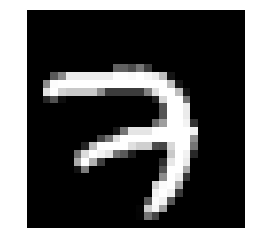

Etiqueta 7


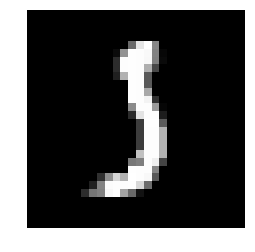

Etiqueta 5


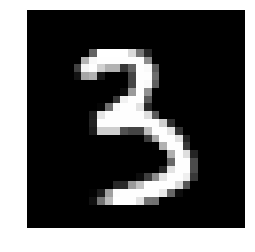

Etiqueta 3


In [4]:
vis_imagen(0, conjunto="train")
vis_imagen(132, conjunto="validation")
vis_imagen(32, conjunto="test")



# RED NEURONAL

In [17]:

### Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784]) 
y = tf.placeholder(tf.float32, shape=[None, 10])

### Variables del modelo

### Parámetros del Modelo
### Capa 1
W_1 = tf.Variable(tf.truncated_normal(shape = [784,512], stddev=0.2))
b_1 = tf.Variable(tf.zeros([512]))

### Capa 2 de salida
W_2 = tf.Variable(tf.truncated_normal(shape = [512,10], stddev=0.2))
b_2 = tf.Variable(tf.zeros([10]))


### Arquitectura de la red neural

def NN(x):
    """
        x: matriz
            su forma  debe ser (m, 784)
            
        regresa la activación de la capa de salida
        matriz de (m, 10)
    """
    # Capa Escondida 1. 
    z_1 = tf.matmul(x,W_1) + b_1 ### Combinación lineal
    a_1  = tf.nn.relu(z_1)     ### Activación (función no lineal)
    
    drop_out = tf.nn.dropout(a_1, keep_prob = 0.8)
    
    # Capa 2. Está es la capa de salida
    z_2 = tf.matmul(drop_out,W_2) + b_2 ### Combinación lineal
    
    return z_2



with tf.Session() as sess:

    ### Función de costo
    y_ = NN(x)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_, labels = y))

    ### Predicciones
    train_pred = tf.nn.softmax(y_) # predicciones en el conjunto de entrenamiento
    ### Nota: la función softmax calcula la probabilidad de cada etiqueta del 0 al 9.
    #Para obtener la predicción necesitamos usar las función tf.argmax(y_,1) o su versión en python np.argmax(y_,1)
    #Así se elige el dígito más probable para la imágen
    #Esto lo hace la función precision

    y_valid = NN(mnist.validation.images)
    valid_pred = tf.nn.softmax(y_valid) # predicciones en el conjunto de validación

    ### Optimizador 

    opt = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

   

    

###  Entrena y Guarda el Modelo

In [18]:
def entrenar(sess, pasos = 5000):
    """
    sess: Sessión de tensorflow
    """
    import os
    sess = tf.Session() #Crea una sessión
    sess.run(tf.global_variables_initializer())

    
    path  = "modelo"
    modelo = path + r"/" + "red_neuronal" #ruta/nombre_del_modelo
    
    saver = tf.train.Saver(max_to_keep=10)
    
    print("Entrenamiento:")
    for i in range(pasos):
        batch = mnist.train.next_batch(100)
        _,costo,predicciones =  sess.run([opt, cross_entropy, train_pred],  feed_dict={x: batch[0], y: batch[1]})

        if (i % 500 == 0):
            print("Costo del minibatch hasta el paso %d: %f" % (i, costo))
            print("Precisión en el conjunto de entrenamiento: %.1f%%" % precision(predicciones, batch[1]))
            print("Precision en el conjunto de validación: %.1f%%" % precision(
            valid_pred.eval(session=sess), mnist.validation.labels))
            print("\n")
        #Guarda el modelo cada 100 iteraciones
        if i % 100 == 0:
            #Verifica que el directorio exista, lo crea si es necesario.
            if not os.path.isdir(path):
                os.mkdir(path)


            saver.save(sess,save_path = modelo, global_step=i)
            print("Iteracion:", i )
            print("Modelo guardado en : %s" % modelo)
            print("\n")



### Entrena

In [19]:

with tf.Session() as sess:
    entrenar(sess, pasos = 5000)
    


Entrenamiento:
Costo del minibatch hasta el paso 0: 8.827548
Precisión en el conjunto de entrenamiento: 10.0%
Precision en el conjunto de validación: 12.2%


Iteracion: 0
Modelo guardado en : modelo/red_neuronal


Iteracion: 100
Modelo guardado en : modelo/red_neuronal


Iteracion: 200
Modelo guardado en : modelo/red_neuronal


Iteracion: 300
Modelo guardado en : modelo/red_neuronal


Iteracion: 400
Modelo guardado en : modelo/red_neuronal


Costo del minibatch hasta el paso 500: 0.200781
Precisión en el conjunto de entrenamiento: 93.0%
Precision en el conjunto de validación: 94.8%


Iteracion: 500
Modelo guardado en : modelo/red_neuronal


Iteracion: 600
Modelo guardado en : modelo/red_neuronal


Iteracion: 700
Modelo guardado en : modelo/red_neuronal


Iteracion: 800
Modelo guardado en : modelo/red_neuronal


Iteracion: 900
Modelo guardado en : modelo/red_neuronal


Costo del minibatch hasta el paso 1000: 0.130206
Precisión en el conjunto de entrenamiento: 94.0%
Precision en el conju

# Carga un modelo desde disco

### Más simple

In [20]:
import tensorflow as tf

path = "modelo"
modelo = path + r"/" + "red_neuronal"

saver = tf.train.Saver()

with tf.Session() as sess:
    
    
    #Carga el modelo.
    print('Cargando el modelo ...')
    ckpts = tf.train.get_checkpoint_state(path)
    print(ckpts)
    print("Ruta del último Checkpoint ", ckpts.model_checkpoint_path)
    
    ### Utiliza el último modelo guardado
    saver.restore(sess,save_path = ckpts.model_checkpoint_path)
    #print(sess.run(W_1))
    
    ############################################################### Entrena el Modelo #################################################
    #entrenar(sess, pasos = 5000,inicializa_variables= True)


Cargando el modelo ...
model_checkpoint_path: "modelo\\red_neuronal-4900"
all_model_checkpoint_paths: "modelo\\red_neuronal-4000"
all_model_checkpoint_paths: "modelo\\red_neuronal-4100"
all_model_checkpoint_paths: "modelo\\red_neuronal-4200"
all_model_checkpoint_paths: "modelo\\red_neuronal-4300"
all_model_checkpoint_paths: "modelo\\red_neuronal-4400"
all_model_checkpoint_paths: "modelo\\red_neuronal-4500"
all_model_checkpoint_paths: "modelo\\red_neuronal-4600"
all_model_checkpoint_paths: "modelo\\red_neuronal-4700"
all_model_checkpoint_paths: "modelo\\red_neuronal-4800"
all_model_checkpoint_paths: "modelo\\red_neuronal-4900"

Ruta del último Checkpoint  modelo\red_neuronal-4900
INFO:tensorflow:Restoring parameters from modelo\red_neuronal-4900


### Cargar un modelo en la iteracion i


In [7]:
import tensorflow as tf

model_dir = "modelo"
modelo = model_dir + r"/" + "red_neuronal"
iteracion = 4700
print("Archivo:",modelo + "-" + str(iteracion))


with  tf.Session() as sess:
    #Carga el modelo.
    print('Cargando el modelo ...')
    saver = tf.train.Saver()
    saver.restore(sess,modelo + "-" + str(iteracion))
    
    #print(sess.run(W_1))
    
    
    ############################################################### Entrena el Modelo #################################################
    #entrenar(sess, pasos = 5000)
    

Archivo: modelo/red_neuronal-4700
Cargando el modelo ...
INFO:tensorflow:Restoring parameters from modelo/red_neuronal-4700
Entrenamiento:
Costo del minibatch hasta el paso 0: 8.153679
Precisión en el conjunto de entrenamiento: 15.0%
Precision en el conjunto de validación: 13.5%


Iteracion: 0
Modelo guardado en : modelo/red_neuronal


Iteracion: 100
Modelo guardado en : modelo/red_neuronal


Iteracion: 200
Modelo guardado en : modelo/red_neuronal


Iteracion: 300
Modelo guardado en : modelo/red_neuronal


Iteracion: 400
Modelo guardado en : modelo/red_neuronal


Costo del minibatch hasta el paso 500: 0.099448
Precisión en el conjunto de entrenamiento: 96.0%
Precision en el conjunto de validación: 95.5%


Iteracion: 500
Modelo guardado en : modelo/red_neuronal


Iteracion: 600
Modelo guardado en : modelo/red_neuronal


Iteracion: 700
Modelo guardado en : modelo/red_neuronal


Iteracion: 800
Modelo guardado en : modelo/red_neuronal


Iteracion: 900
Modelo guardado en : modelo/red_neuron

###  Usando sess = tf.Session()

In [22]:
import tensorflow as tf

model_dir = "modelo"
modelo = model_dir + r"/" + "red_neuronal"
iteracion = 4700
print("Archivo:",modelo + "-" + str(iteracion))

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

#Carga el modelo.
print('Cargando el modelo ...')
saver = tf.train.import_meta_graph(modelo + '-'+ str(iteracion) +'.meta')
saver.restore(sess,modelo + "-" + str(iteracion))

############################################################### Entrena el Modelo #################################################
#entrenar(sess, pasos = 5000,inicializa_variables= True)


Archivo: modelo/red_neuronal-4700
Cargando el modelo ...
INFO:tensorflow:Restoring parameters from modelo/red_neuronal-4700


# Precisión en el conjunto de prueba

In [23]:
y_test = NN(mnist.test.images)
test_prediction = tf.nn.softmax(y_test)
print("Precisión en el conjunto de PRUEBA: %.1f%%" % precision(test_prediction.eval(session = sess), mnist.test.labels))    

Precisión en el conjunto de PRUEBA: 97.0%


Predicción: 1


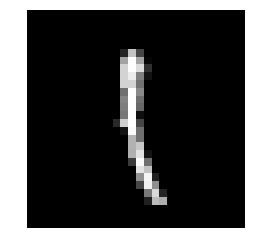

Etiqueta 1


In [24]:
indice = 251
p = tf.argmax(NN(mnist.test.images[indice:indice+1]).eval(session = sess),1)
print("Predicción:", sess.run(p)[0])
vis_imagen(indice, conjunto="test")

In [25]:
def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency 
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL 
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format

        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

# Usa tu propia imágen

### Cambia el nombre de de la variabel imagen por la tuya.
#### La imágen debe se una imágen cuadrada y cada dimensión mayor a 28.
#### Ej. una  imágen de (512,512) en formato png

In [26]:
from PIL import Image
imagen = "numero8.png"
img = Image.open(imagen)
img = remove_transparency(img).convert('L')

if  img.size != (28,28):
    img.thumbnail((28,28), Image.ANTIALIAS)

entrada = np.array(img, dtype = np.float32)
entrada = entrada.reshape((1,784))
entrada = entrada/255.0
        
p = tf.argmax(NN(entrada).eval(session = sess),1)
print("Imágen:{}".format(imagen))
img.show()
print("Predicción:", sess.run(p)[0])




Imágen:numero8.png
Predicción: 8
